In [59]:
# Training setup
train_input = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/training_images'
train_output = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/training_masks'

In [83]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from PIL import Image
import os
import numpy as np 
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR

def map_mask_to_classes(mask):
    # Mappa 0 a 0, 128 a 1 e 255 a 2
    mask_transformed = torch.zeros_like(mask)
    mask_transformed[mask == 0] = 0
    mask_transformed[mask == 128] = 1
    mask_transformed[mask == 255] = 2
    return mask

image_transform = transforms.Compose([
    Resize((256, 256)), #256
    transforms.ToTensor(),
    transforms.Normalize(mean=[107.77957153320312], std=[37.14806365966797])
])

mask_transform = transforms.Compose([
    Resize((256, 256)), #256
    transforms.ToTensor(), 
    transforms.Lambda(map_mask_to_classes)  # Applica la mappatura personalizzata
])


class RetinaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = mask_transform(mask)  # Assicurati che la trasformazione della maschera sia corretta

        # Estrai coordinate e intensità
        coords = np.meshgrid(np.arange(256), np.arange(256), indexing='ij')
        coords = np.stack(coords, axis=-1).reshape(-1, 2)
        coords = coords.astype(np.float32) / 256  # normalizzazione delle coordinate
        intensities = np.array(image).reshape(-1, 1) # / 255.0  # normalizzazione delle intensità

        inputs = np.concatenate([coords, intensities], axis=1)
        inputs = torch.tensor(inputs, dtype=torch.float32)

        # print("Coords shape:", coords.shape)
        # print("Intensities shape:", intensities.shape)

        return inputs, torch.tensor(np.array(mask), dtype=torch.long).flatten()


# Dice Loss
class MultiClassDiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1e-6):
        super(MultiClassDiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Assicurati che la forma di targets_one_hot sia compatibile
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()
        
        # Riorganizza inputs se necessario (ad esempio, se non è già nel formato batch_size x N x num_classes)
        if inputs.dim() == 2:
            inputs = inputs.unsqueeze(0)

        inputs = torch.sigmoid(inputs)  # Applica la funzione sigmoid
        
        # Verifica la necessità di permute (solo se le dimensioni non corrispondono)
        if targets_one_hot.dim() == 3 and inputs.dim() == 3 and inputs.shape[1] == targets_one_hot.shape[2]:
            targets_one_hot = targets_one_hot.permute(0, 2, 1)

        # Calcola intersection e union
        intersection = (inputs * targets_one_hot).sum(dim=2)
        union = (inputs + targets_one_hot).sum(dim=2)
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()
    

class PositionalEncoding(nn.Module):
    def __init__(self, num_freqs):
        super(PositionalEncoding, self).__init__()
        self.num_freqs = num_freqs

    def forward(self, x):
        # frequencies = [num_freqs]
        frequencies = torch.linspace(0, self.num_freqs - 1, self.num_freqs, device=x.device)
        frequencies = 2.0 ** frequencies
        
        # Modifica le frequenze per adattarsi alle dimensioni di x
        # x.shape = [batch, N, features]
        # Devi moltiplicare per ogni coordinata (sia x che y), quindi duplica le frequenze
        frequencies = frequencies.view(1, 1, -1)  # Shape [1, 1, num_freqs]
        
        # Raddoppia le frequenze per coprire sia sin che cos per ogni coordinata
        frequencies = frequencies.repeat(1, 1, 2)  # Shape [1, 1, 2*num_freqs]

        # Calcola sin e cos
        x = x.unsqueeze(-1)  # Aggiungi una dimensione per le frequenze
        x = x * frequencies  # Applica le frequenze a ogni coordinata
        x = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)  # Calcola sin e co
        
        # Rimetti in forma corretta: [batch, N, num_features]
        return x.view(x.shape[0], x.shape[1], -1)




# Sine Layer
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, omega_0=30.0):
        super(SineLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.omega_0 = omega_0

    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))

class Siren(nn.Module):
    def __init__(self, img_dim=256, hidden_size=192, out_features=1, num_freqs=10, num_layers=3):
        super(Siren, self).__init__()
        self.img_dim = img_dim
        self.hidden_size = hidden_size
        self.pos_enc = PositionalEncoding(num_freqs)
        # Sine Layer as the first layer
        # self.first_sine = SineLayer(2 * num_freqs * 2 + 1, hidden_size)
        self.first_sine = SineLayer(81, hidden_size)

        self.mlp = nn.Sequential()
        
        # Adding additional layers
        for i in range(num_layers - 1):
            self.mlp.add_module("linear{}".format(i), nn.Linear(hidden_size, hidden_size))
            self.mlp.add_module("relu{}".format(i), nn.ReLU())
        
        # Output layer
        self.final_layer = nn.Linear(hidden_size, out_features)

    def forward(self, coords_intensities):
        coords, intensities = coords_intensities[..., :-1], coords_intensities[..., -1]
        x = self.pos_enc(coords)
        # print("Shape of x after pos_enc:", x.shape)
        intensities = intensities.unsqueeze(-1)  # Adds the necessary last dimension
        # print("Shape of intensities after unsqueeze:", intensities.shape)
        
        # Ensure that intensities match the dimensions of x for concatenation
        if intensities.dim() < x.dim():
            intensities = intensities.expand_as(x[..., :1])  # Match dimensions

        x = torch.cat([x, intensities], dim=-1)  # Ensure that dimensions match
        # print("Shape of x after concatenation:", x.shape)
        x = self.first_sine(x)
        x = self.mlp(x)
        x = self.final_layer(x)
        return torch.sigmoid(x)  # Output should be between 0 and 1





# Impostazione di training
dataset = RetinaDataset(train_input, train_output, image_transform=image_transform, mask_transform=mask_transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Siren(img_dim=256, hidden_size=256, out_features=1, num_freqs=10, num_layers=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

epochs_list = []
error_list = []

# def train(model, loader, optimizer, criterion, , epochs):
def train(model, loader, optimizer, criterion, scheduler, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in loader:
            # print("Inputs shape:", inputs.shape)
            # print("Labels shape:", labels.shape)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            # print(f"Input size {inputs.size()}")
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)  # Passa la perdita al scheduler
            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(loader)}')
        # print("Current learning rate:", scheduler.optimizer.param_groups[0]['lr'])
        epochs_list.append(epoch+1)
        error_list.append(total_loss / len(loader))

criterion = MultiClassDiceLoss(num_classes=3).to(device) 

# scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.8)
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)
train(model, loader, optimizer, criterion, scheduler, epochs=30)



Epoch 1, Average Loss: 0.5431681197622548
Epoch 2, Average Loss: 0.542111873626709
Epoch 3, Average Loss: 0.542111873626709
Epoch 4, Average Loss: 0.542111873626709
Epoch 5, Average Loss: 0.542111873626709
Epoch 6, Average Loss: 0.542111873626709
Epoch 7, Average Loss: 0.542111873626709
Epoch 8, Average Loss: 0.542111873626709
Epoch 9, Average Loss: 0.542111873626709
Epoch 10, Average Loss: 0.542111873626709
Epoch 11, Average Loss: 0.542111873626709
Epoch 12, Average Loss: 0.542111873626709
Epoch 13, Average Loss: 0.542111873626709
Epoch 14, Average Loss: 0.542111873626709
Epoch 15, Average Loss: 0.542111873626709
Epoch 16, Average Loss: 0.542111873626709
Epoch 17, Average Loss: 0.542111873626709
Epoch 18, Average Loss: 0.542111873626709
Epoch 19, Average Loss: 0.542111873626709
Epoch 20, Average Loss: 0.542111873626709
Epoch 21, Average Loss: 0.542111873626709
Epoch 22, Average Loss: 0.542111873626709
Epoch 23, Average Loss: 0.542111873626709
Epoch 24, Average Loss: 0.542111873626709


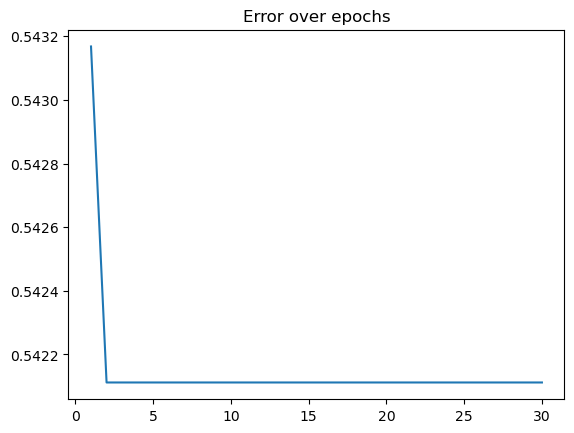

In [89]:
import matplotlib.pyplot as plt

plt.plot(epochs_list, error_list)
plt.title('Error over epochs')
plt.show()

In [90]:
torch.save(model.state_dict(), 'retina_segmentation_model_2.pth')

In [91]:
test_input = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/test'


tensor(1.)


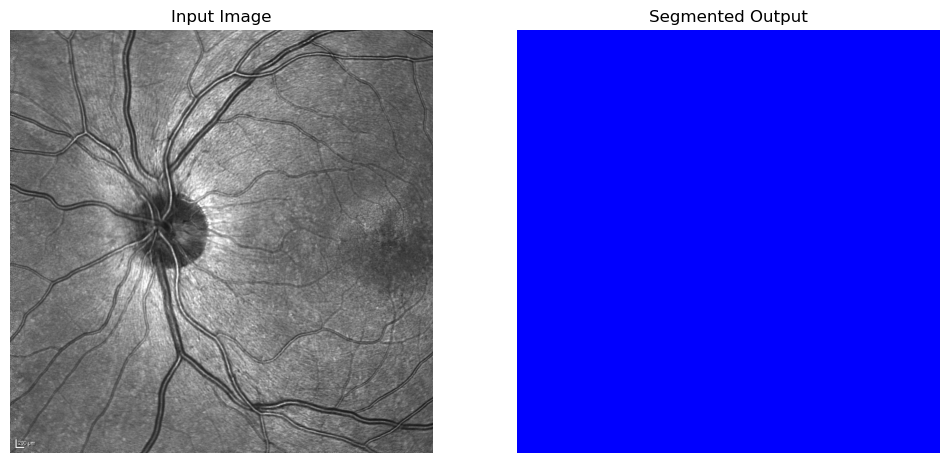

tensor(1.)


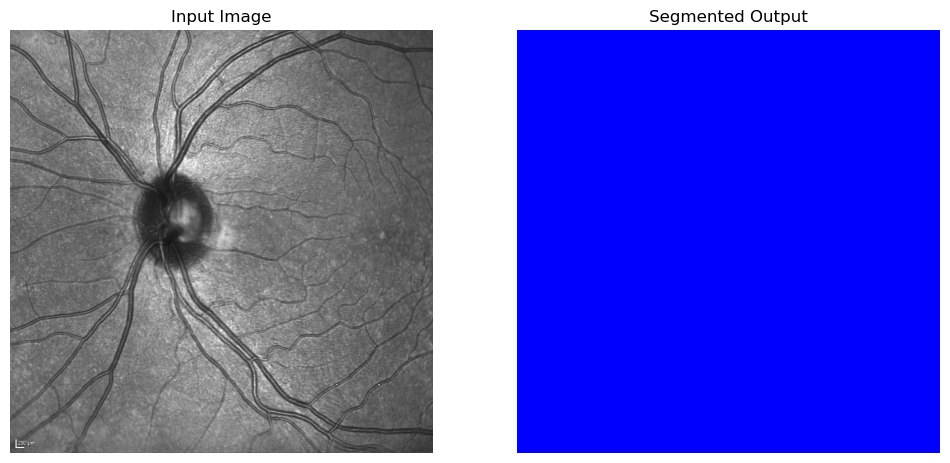

tensor(1.)


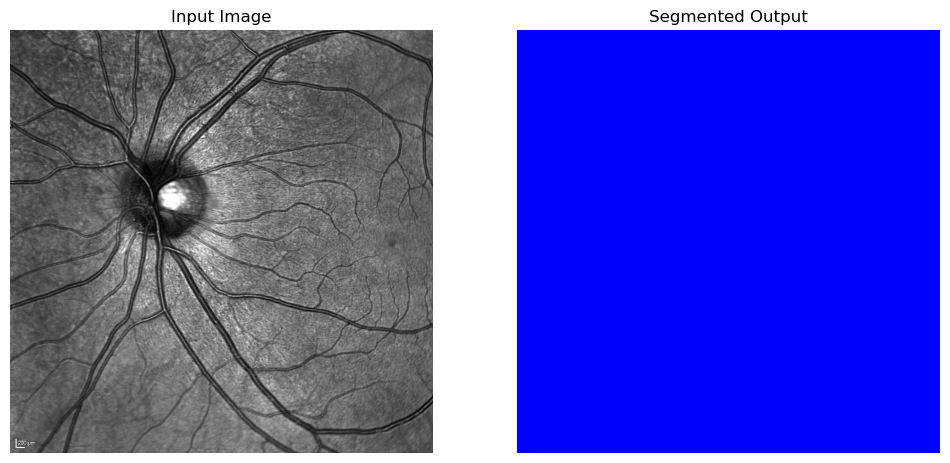

tensor(1.)


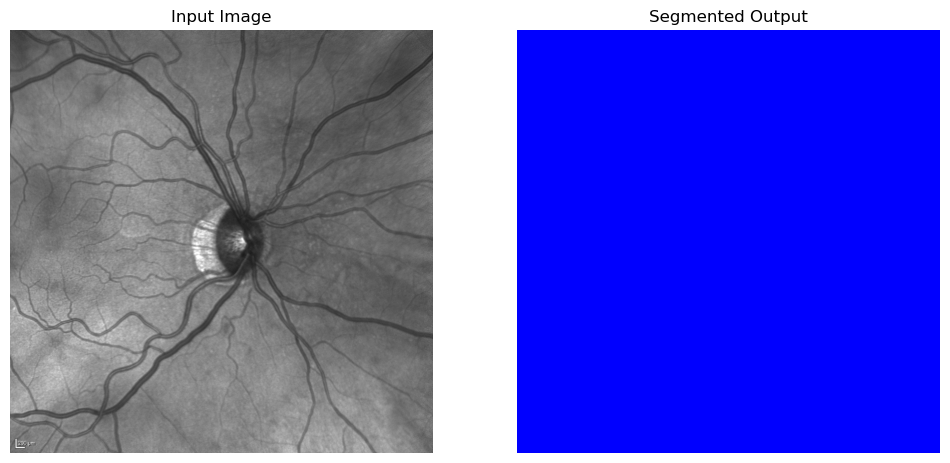

tensor(1.)


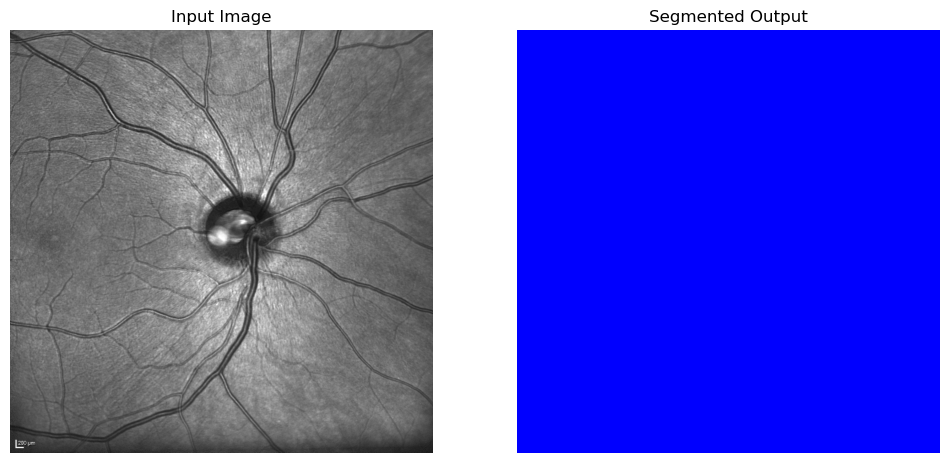

tensor(1.)


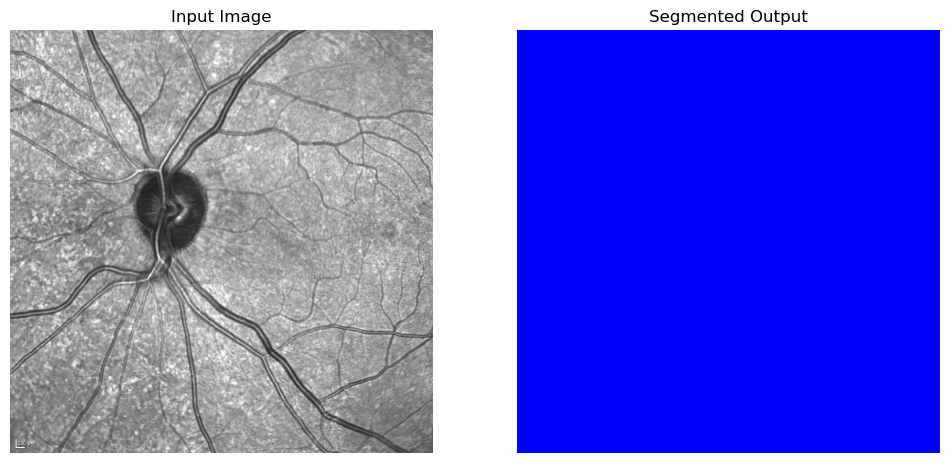

tensor(1.)


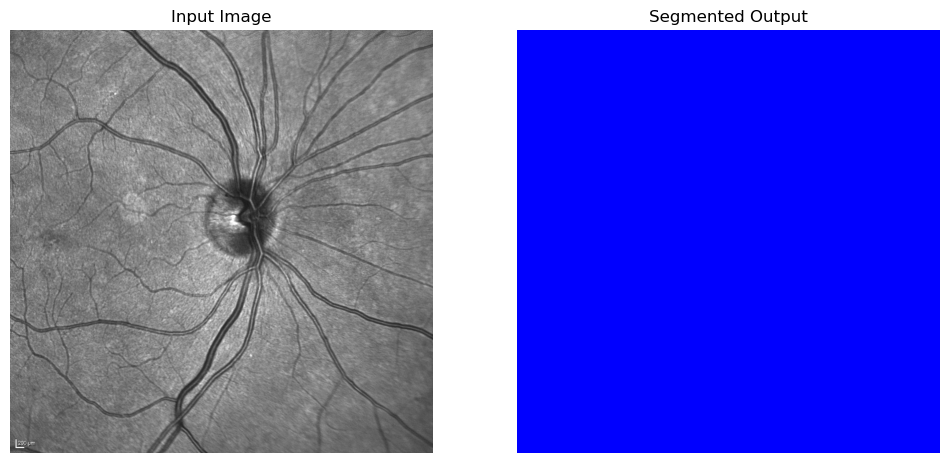

tensor(1.)


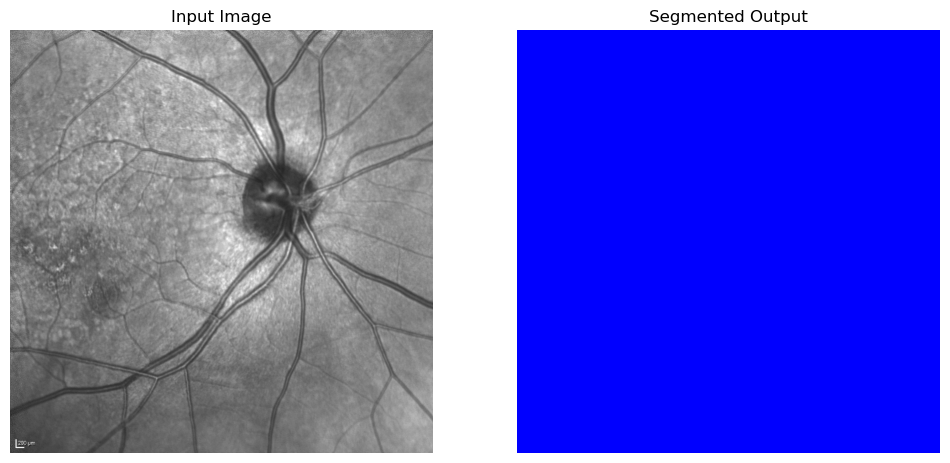

tensor(1.)


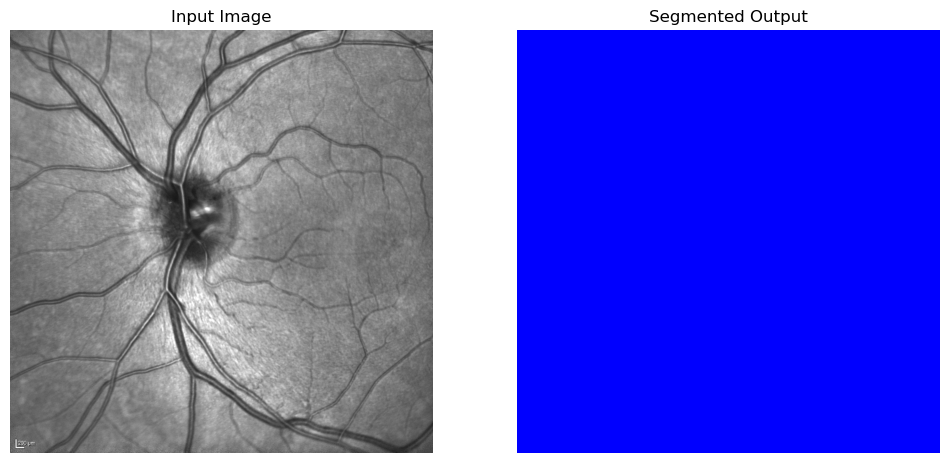

tensor(1.)


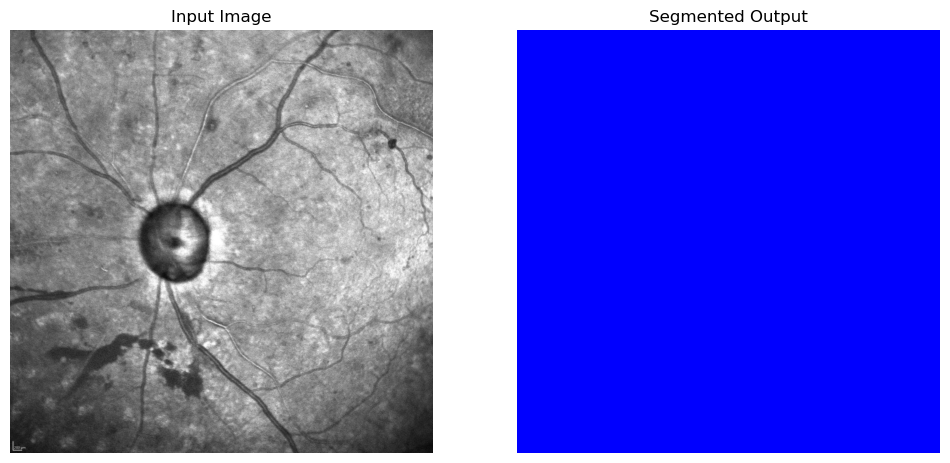

tensor(1.)


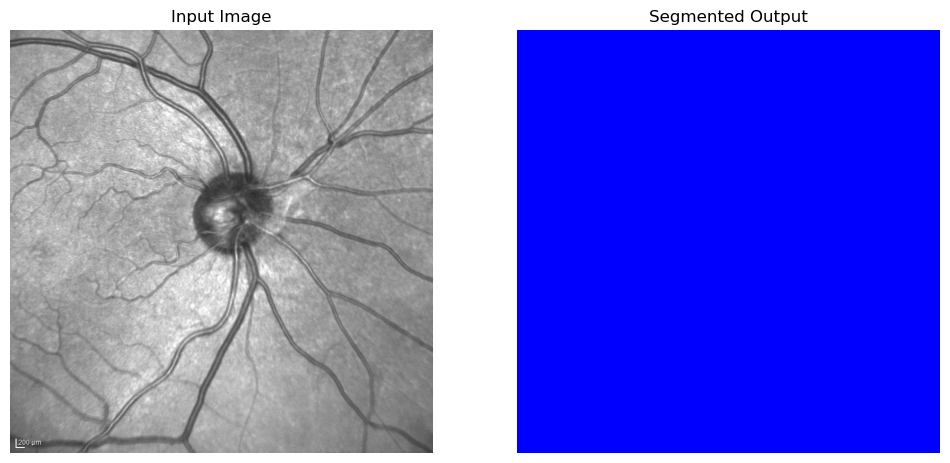

tensor(1.)


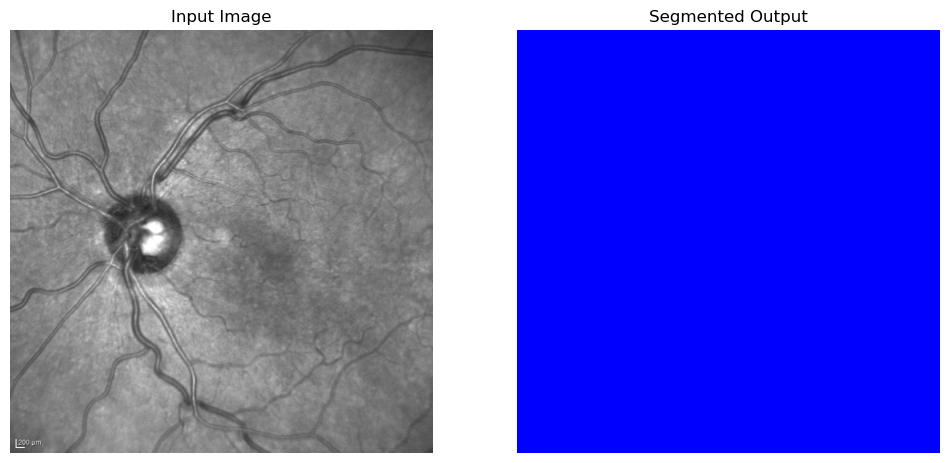

tensor(1.)


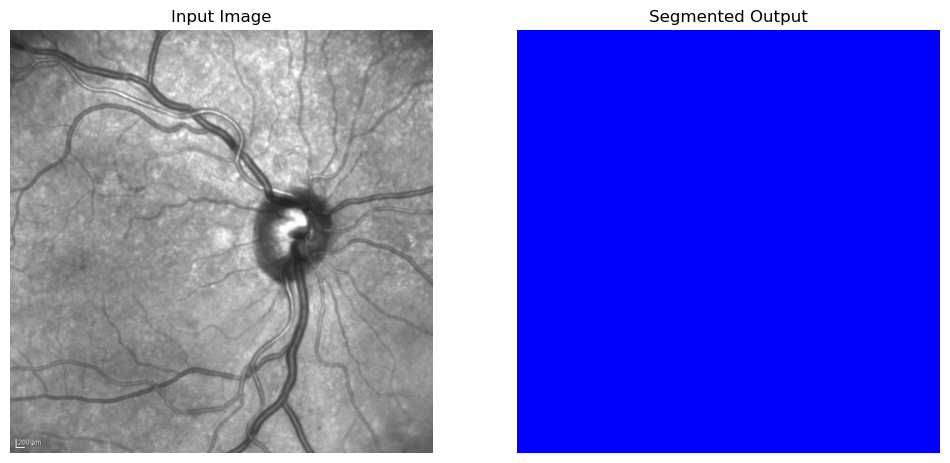

tensor(1.)


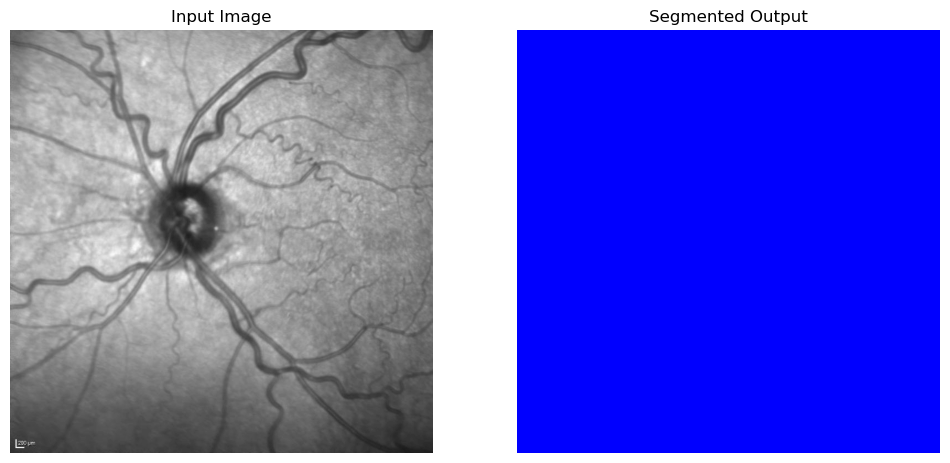

tensor(1.)


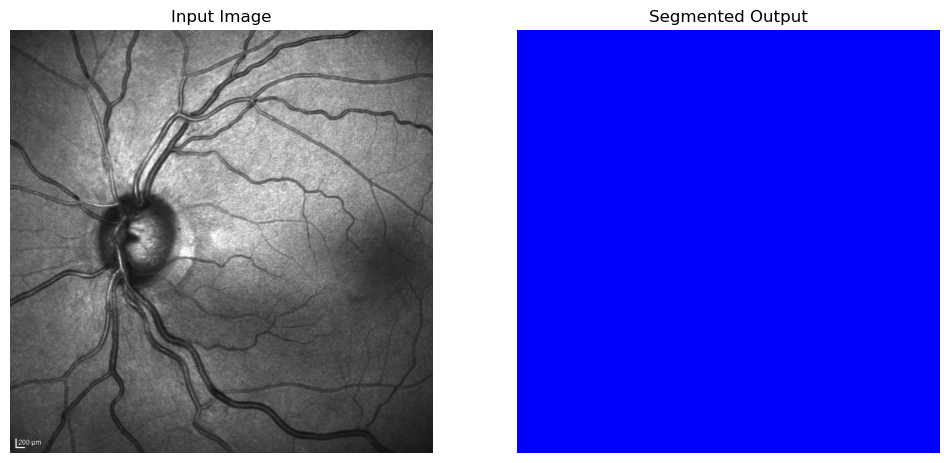

tensor(1.)


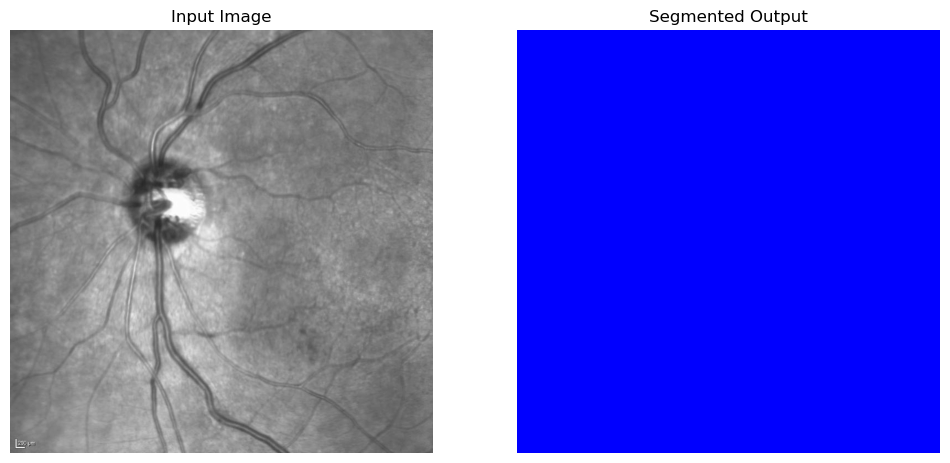

tensor(1.)


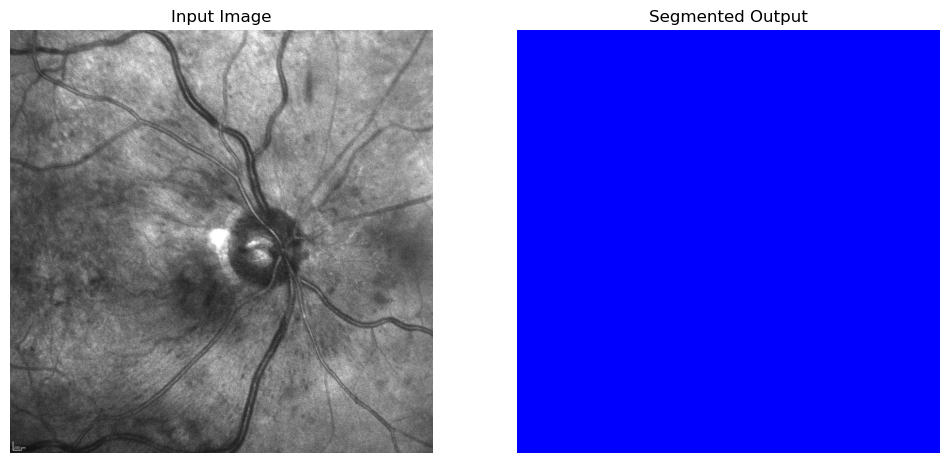

tensor(1.)


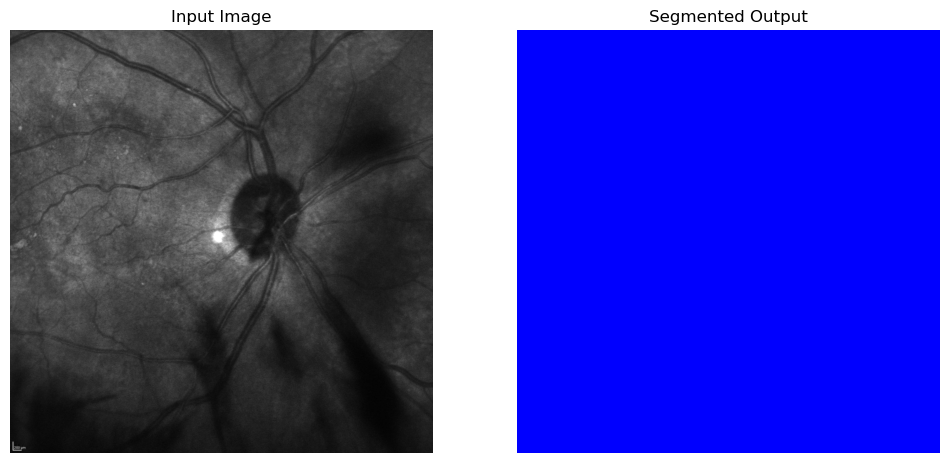

tensor(1.)


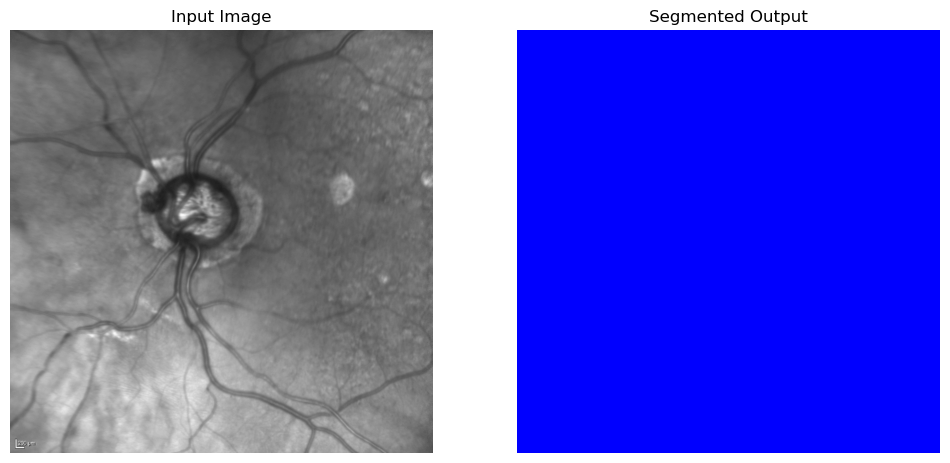

In [92]:
import torch
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def custom_round(output):
    output = torch.where(output < 0.33, torch.tensor(0.0, device=output.device),
                         torch.where(output < 0.66, torch.tensor(1.0, device=output.device), torch.tensor(2.0, device=output.device)))
    return output

# Assumi che Siren sia già definito altrove nel codice
model = Siren(img_dim=256, hidden_size=256, out_features=1, num_freqs=10, num_layers=5).to(device)
model.load_state_dict(torch.load('retina_segmentation_model_2.pth'))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Funzione per processare e visualizzare le immagini
def process_and_visualize(test_path):
    transform = Compose([
        Resize((256, 256)),
        ToTensor(),
        transforms.Normalize(mean=[107.77957153320312], std=[37.14806365966797])
    ])

    colors = [(1, 1, 1), (1, 0, 0), (0, 0, 1)]  # Bianco, Rosso, Blu
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=3)

    images = os.listdir(test_path)
    for img_name in images:
        img_path = os.path.join(test_path, img_name)
        image = Image.open(img_path).convert('L')
        image_tensor = transform(image)  # Immagine normalizzata
        coords = np.meshgrid(np.arange(256), np.arange(256), indexing='ij')
        coords = np.stack(coords, axis=-1).reshape(-1, 2)
        coords = coords.astype(np.float32) / 256  # Normalizza le coordinate
        intensities = image_tensor.numpy().flatten().reshape(-1, 1)

        inputs = np.concatenate([coords, intensities], axis=1)
        inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).to(device)  # Crea batch size di 1

        with torch.no_grad():
            output = model(inputs)
            # Assumi che il modello restituisca un'immagine segmentata
            output = output.view(256, 256)
            print(output.min())
            # break
            output = custom_round(output)

        # Visualizza i risultati
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title('Input Image')
        ax[0].axis('off')

        ax[1].imshow(output.cpu().numpy(), cmap=cmap, vmin=0, vmax=2)
        ax[1].set_title('Segmented Output')
        ax[1].axis('off')

        plt.show()


# Chiamata alla funzione con il percorso di test
process_and_visualize(test_input)


In [ ]:
# from PIL import Image
# import os

# def analyze_image(image_path):
#     # Carica l'immagine usando Pillow
#     with Image.open(image_path) as img:
#         # Mostra l'immagine

#         # Ottieni le dimensioni dell'immagine
#         width, height = img.size
#         print(f"Dimensions: {width}x{height} pixels")

#         # Conta i canali di colore
#         mode = img.mode
#         print(f"Color mode: {mode}")
        
#         # Calcola il rapporto di aspetto
#         aspect_ratio = width / height
#         print(f"Aspect Ratio: {aspect_ratio:.2f}")

#         # Mostra la profondità di bit (basato sul tipo di mode)
#         if mode == "1":
#             depth = 1
#         elif mode == "L" or mode == "P":
#             depth = 8
#         elif mode == "RGB" or mode == "YCbCr":
#             depth = 8 * 3
#         elif mode == "RGBA" or mode == "CMYK":
#             depth = 8 * 4
#         else:
#             depth = "Unknown"
        
#         print(f"Bit Depth per Channel: {depth}")

#         # Calcola e mostra la dimensione del file
#         file_size = os.path.getsize(image_path)
#         print(f"File Size: {file_size} bytes")

# # Utilizzo della funzione
# image_path = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/training_images/IR_Case_011.png'
# analyze_image(image_path)


In [ ]:
# Including also intensiti in the code
# --> coordinates pixel + intensity
# --> cords+intensity input --> cords + intersity mask
# 1 sinlayer + fully connected layers that takes the positional encoding and the intensity 

In [ ]:
# from PIL import Image
# import numpy as np

# def analyze_mask(mask_path):
#     # Apertura del file della maschera
#     mask = Image.open(mask_path).convert('L')
#     mask_array = np.array(mask)

#     # Trova i valori unici nella maschera
#     unique_values = np.unique(mask_array)
    
#     # Stampa dei valori unici
#     print(f'Unique values in the mask: {unique_values}')
    
#     # Verifica se tutti i valori sono tra -1, 0, e 1
#     if set(unique_values).issubset({-1, 0, 1}):
#         print("All values are within the expected set (-1, 0, 1).")
#     else:
#         print("Unexpected values found. Please check the mask.")

# # Esempio di come chiamare la funzione
# mask_path = 'RAVIR Dataset/train/training_masks/IR_Case_011.png'  # Sostituisci con il percorso effettivo del file della maschera
# analyze_mask(mask_path)


Unique values in the mask: [  0 128 255]
Unexpected values found. Please check the mask.


In [ ]:
# import os
# import numpy as np
# from PIL import Image
# from torchvision import transforms
# from torch.utils.data import DataLoader, Dataset

# class ImageDataset(Dataset):
#     def __init__(self, directory, convert_mode='L'):
#         self.directory = directory
#         self.images = os.listdir(directory)
#         self.convert_mode = convert_mode

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.directory, self.images[idx])
#         image = Image.open(img_path).convert(self.convert_mode)
#         return np.array(image, dtype=np.float32)

# def calculate_mean_std(directory, convert_mode='L'):
#     dataset = ImageDataset(directory, convert_mode)
#     loader = DataLoader(dataset, batch_size=1, num_workers=0)

#     # Inizializza somme e conteggi per media e varianza
#     pixel_sum = 0
#     pixel_sq_sum = 0
#     num_pixels = 0

#     for image in loader:
#         pixel_sum += image.sum()
#         pixel_sq_sum += (image ** 2).sum()
#         num_pixels += image.numel()

#     # Calcola media e deviazione standard
#     mean = pixel_sum / num_pixels
#     std = ((pixel_sq_sum / num_pixels) - (mean ** 2)) ** 0.5

#     return mean.item(), std.item()

# # Percorsi alle directory delle immagini e delle maschere
# image_dir = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/training_images'  # Sostituisci con il percorso effettivo delle immagini
# mask_dir = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/training_masks'    # Sostituisci con il percorso effettivo delle maschere

# # Calcolo della media e della deviazione standard per le immagini
# image_mean, image_std = calculate_mean_std(image_dir)
# print(f'Image Mean: {image_mean}, Image Std: {image_std}')

# # Calcolo della media e della deviazione standard per le maschere
# mask_mean, mask_std = calculate_mean_std(mask_dir)
# print(f'Mask Mean: {mask_mean}, Mask Std: {mask_std}')


Image Mean: 107.77957153320312, Image Std: 37.14806365966797
Mask Mean: 25.670705795288086, Mask Std: 70.7190933227539
